In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import dask
dask.config.set(scheduler = "single-threaded")

In [2]:
# Load data sets
# --------------------------------------

ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpaeriprof3feltzC1.*.cdf',          combine='by_coords', parallel = True)
# ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpaeriprof3feltzC1.*.cdf', combine='by_coords', parallel = True)

In [3]:
# Get reference dates from each data set
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
# ref_date2 = np.datetime64(datetime(pd.to_datetime(ds2.time[0].values).year, pd.to_datetime(ds2.time[0].values).month, pd.to_datetime(ds2.time[0].values).day))

In [224]:
# # Ensure reference dates match
# # --------------------------------------

# assert(ref_date1 == ref_date2)

In [4]:
# Compute new time axis
# --------------------------------------

ds1['time'] = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values
# ds2['time'] = ((ds2.time - ref_date2) / np.timedelta64(1, 'D')).values

In [5]:
# Get interpolation values
# --------------------------------------

min_date = ds1['time'][0].values
max_date = ds1['time'][-1].values

interval = (1/4)/24

common_time   = np.arange(min_date, max_date, interval)
common_height = np.linspace(4, 2000, 200)

In [6]:
# Regularize data sets
# --------------------------------------

ds1 = ds1.interp(time = common_time, height = common_height)

qc_flag = np.zeros(common_time.shape)

total_h = len(common_height)

temps = ds1['virPoTemp'].values

for t in range(common_time.shape[0]):
    qc_flag[t] = np.sum(np.isnan(temps[:, t])) / total_h

qc_flag = qc_flag < 1/2

ds1 = xr.Dataset({
'virPoTemp': xr.DataArray(
            data   = temps[:, qc_flag],   # enter data here
            dims   = ['height', 'time'],
            coords = {'height': common_height, 'time': common_time[qc_flag]},
),
    })

(0.0, 2000.0)

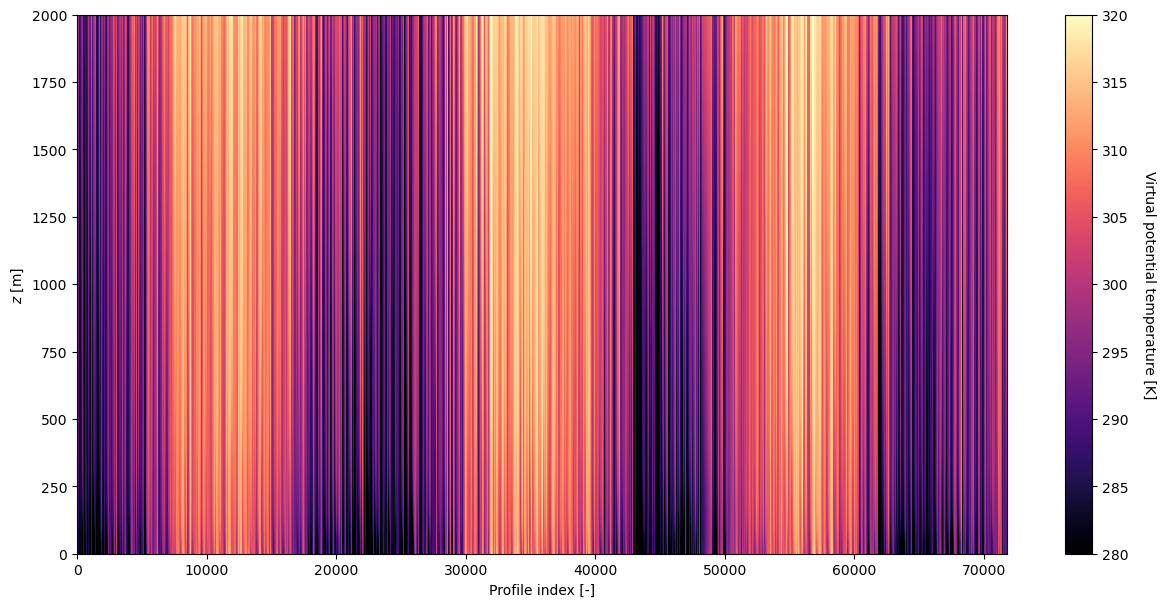

In [8]:
# Plot rectified data
# --------------------------------------

fig,ax = plt.subplots(1, 1, figsize = (15, 7))

cntf = ax.pcolormesh(range(len(ds1.time)), ds1.height, ds1.virPoTemp, vmin = 280, vmax = 320, cmap='magma')

cbar = plt.colorbar(cntf)
cbar.set_label('Virtual potential temperature [K]', rotation = -90, labelpad = 20)
ax.set_ylabel("$z$ [m]")
ax.set_xlabel("Profile index [-]")
ax.set_ylim([0, 2000])
# plt.axvline(x = 750, color = 'w', linestyle = '-')

Text(0.5, 1.0, 'Days from reference: 15.5')

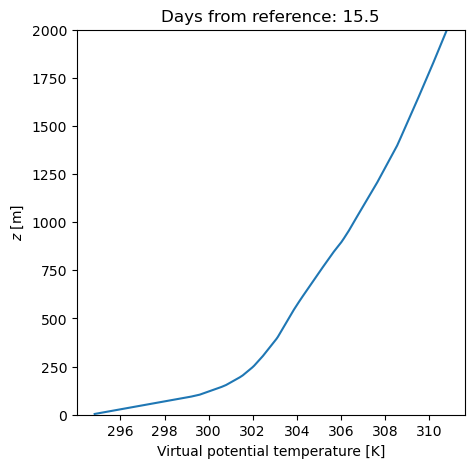

In [229]:
# Plot sample component profiles
# --------------------------------------

fig,ax = plt.subplots(figsize = (5, 5))

i = 750

ax.plot(ds1.virPoTemp[:,i], ds1.height)
ax.set_xlabel('Virtual potential temperature [K]')
ax.set_ylabel('$z$ [m]')
ax.set_ylim([0, 2000])
ax.set_title('Days from reference: ' + str(round(float(ds1.time[i].values), 2)))

In [230]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(ds1.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds1.time.values

for i in range(ds1.time.shape[0]):
    new_ref_times[i] = np.datetime64(pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

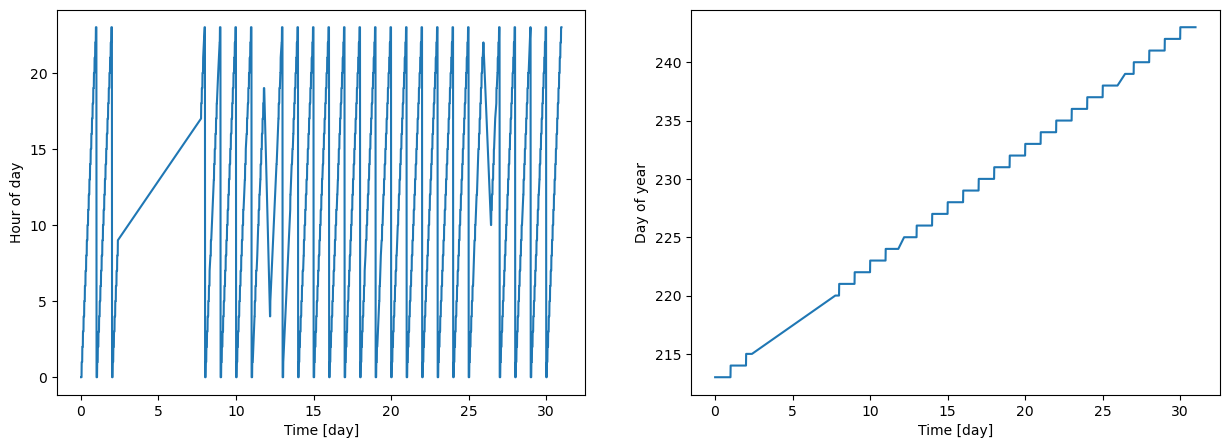

In [231]:
# Confirm time axes are correct
# --------------------------------------

fig,ax = plt.subplots(1,2,figsize = (15, 5))

ax[0].plot(times, hr_per_day)
# ax[0].plot(range(len(times)), hr_per_day)
ax[0].set_xlabel('Time [day]')
ax[0].set_ylabel('Hour of day')

ax[1].plot(times, day_per_yr)
# ax[1].plot(range(len(times)), day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [232]:
# Save data
# --------------------------------------

ds1['hr_day'] = (('time'), hr_per_day)
ds1['day_yr'] = (('time'), day_per_yr)

ds1.to_netcdf('/Users/smata/Downloads/processedData/temperatureData.nc')

ds1

<xarray.Dataset>
Dimensions:    (height: 200, time: 2088)
Coordinates:
  * height     (height) float64 4.0 14.03 24.06 ... 1.98e+03 1.99e+03 2e+03
  * time       (time) float64 0.007616 0.01803 0.02845 ... 30.97 30.98 30.99
Data variables:
    virPoTemp  (height, time) float64 313.5 313.1 313.0 ... 314.6 314.2 314.2
    hr_day     (time) float64 0.0 0.0 0.0 0.0 1.0 ... 22.0 22.0 23.0 23.0 23.0
    day_yr     (time) float64 213.0 213.0 213.0 213.0 ... 243.0 243.0 243.0